In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.image import imread
from matplotlib.image import imsave

import pycuda.driver as cuda
import pycuda.compiler as compiler

# Algorithm Implementation

In [23]:
def initialize_centroids(data, k):
    """
    Initializes the centroids by randomly selecting k points from the data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :return: A 2D numpy array of k centroids
    """
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    return centroids


In [24]:
def closest_centroid(data, centroids):
    """
    Finds the index of the closest centroid for each data point.

    :param data: A 2D numpy array where each row is a data point
    :param centroids: A 2D numpy array of current centroids
    :return: A 1D numpy array where each element is the index of the closest centroid for the corresponding data point
    """
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


In [25]:
def compute_centroids(data, labels, k):
    """
    Computes the new centroids as the mean of the data points assigned to each cluster.

    :param data: A 2D numpy array where each row is a data point
    :param labels: A 1D numpy array of cluster indices corresponding to the closest centroids
    :param k: Number of clusters
    :return: A 2D numpy array of the new centroids
    """
    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))
    
    for i in range(k):
        points_in_cluster = data[labels == i]
        if points_in_cluster.size:
            centroids[i] = points_in_cluster.mean(axis=0)
    
    return centroids


In [26]:
def k_means(data, k, max_iters=100, tol=1e-4):
    """
    Performs K-Means clustering on the input data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :param max_iters: Maximum number of iterations to run the algorithm
    :param tol: Tolerance for convergence, i.e., if the centroids do not move much, the algorithm will stop
    :return: A tuple of (centroids, labels) where centroids is a 2D numpy array of final centroids and
             labels is a 1D numpy array of cluster indices for each data point
    """
    # Step 1: Initialize the centroids
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        # Step 2: Assign each data point to the closest centroid
        labels = closest_centroid(data, centroids)

        # Step 3: Calculate new centroids as the mean of the points in each cluster
        new_centroids = compute_centroids(data, labels, k)

        # Step 4: Check for convergence (if centroids do not change much)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels


# Testing the Algorithm

In [27]:
def generate_data():
    nPerClust_SA = 100
    C1 = [1,1]
    C2 = [5,1]
    C3 = [3,-2]
    C4 = [4,4]
    blur = 1
    radius = np.array([0.8,0.8,0.8,0.8])
    
    C1Data = np.array([C1[0]+radius[0]*np.random.randn(nPerClust_SA)*blur , C1[1]+radius[0]*np.random.randn(nPerClust_SA)*blur ])
    C2Data = np.array([C2[0]+radius[1]*np.random.randn(nPerClust_SA)*blur , C2[1]+radius[1]*np.random.randn(nPerClust_SA)*blur ])
    C3Data = np.array([C3[0]+radius[2]*np.random.randn(nPerClust_SA)*blur , C3[1]+radius[2]*np.random.randn(nPerClust_SA)*blur ])
    C4Data = np.array([C4[0]+radius[3]*np.random.randn(nPerClust_SA)*blur , C4[1]+radius[3]*np.random.randn(nPerClust_SA)*blur ])

    np_data = np.hstack((C1Data,C2Data,C3Data,C4Data)).T

    Label1 = np.zeros((np.max(C1Data.shape),1))
    Label2 = Label1 + 1
    Label3 = Label1 + 2
    Label4 = Label1 + 3
    np_labels = np.vstack((Label1,Label2,Label3,Label4))
    
    return np_labels, np_data

In [28]:
# Plot the clusters
def plot_clusters(np_data, labels, k, centroids):
    colors = ['ro', 'go', 'bo', 'mo', 'co', 'yo', 'ko']  # Colors for different clusters

    for i in range(k):
        cluster_data = np_data[labels == i]
        plt.plot(cluster_data[:, 0], cluster_data[:, 1], colors[i % len(colors)], label=f"Cluster {i+1}")
        plt.plot(centroids[i][0],centroids[i][1], 'ko', label=f"Cluster {i+1}")

    plt.legend()
    plt.title(f"Clusters for k={k}")
    plt.show()

In [29]:
def cluster_and_plot(np_data):
    for k in [2, 3, 4]:  # Perform clustering for k=2, 3, and 4
        centroids, labels = k_means(np_data, k)
        plot_clusters(np_data, labels, k, centroids)


# Plotting the Results

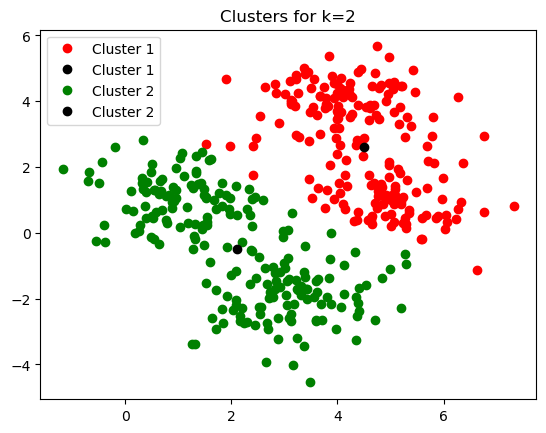

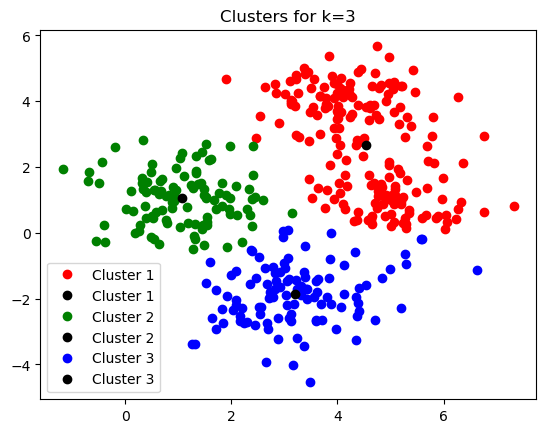

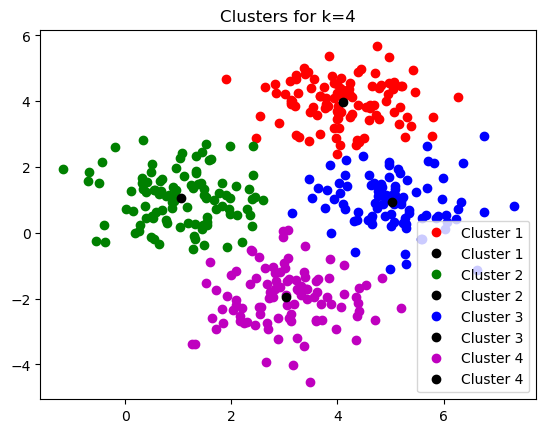

In [30]:
# Main script
labels, np_data = generate_data()  # Generate the data

# Cluster and plot for 2, 3, and 4 clusters
cluster_and_plot(np_data)

# Evaluating the Algorithm

In [31]:
# Function to compute the Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# Function to calculate inertia (within-cluster sum of squares)
def calculate_inertia(X, clusters, centroids):
    inertia = 0
    for i, point in enumerate(X):
        centroid = centroids[clusters[i]]
        inertia += euclidean_distance(point, centroid)**2
    return inertia/X.shape[0]

In [32]:
# Function to plot the error vs number of clusters
def plot_error_vs_clusters(k_values, errors):
    """
    Plot the error of K-Means vs number of clusters.
    :param k_values: List of k values (number of clusters)
    :param errors: List of errors corresponding to each k
    """
    plt.plot(k_values, errors, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Total Error')
    plt.title('K-Means Error vs Number of Clusters')
    plt.grid(True)
    plt.show()

# Plotting the Error

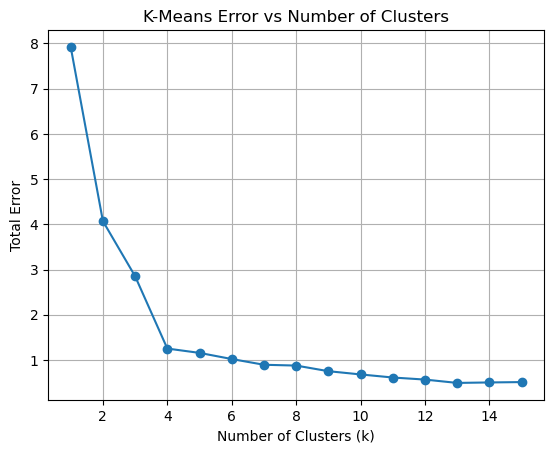

In [33]:
# Evaluate K-Means for k = 1 to 15 and calculate errors
k_values = range(1, 16)
errors = []

for k in k_values:
    centroids, labels = k_means(np_data, k)
    error = calculate_inertia(np_data, labels, centroids)
    errors.append(error)

# Plot the error as a function of the number of clusters
plot_error_vs_clusters(k_values, errors)

# Limitations of k-means

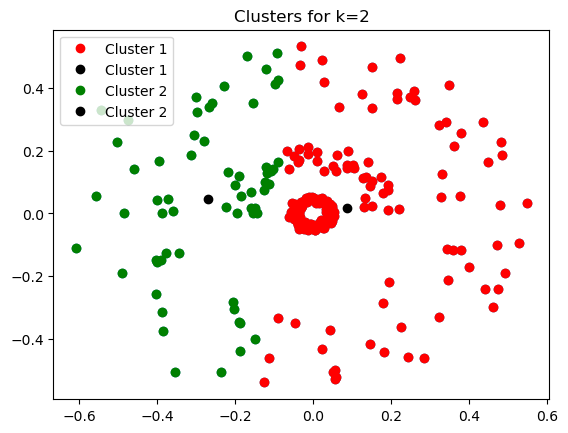

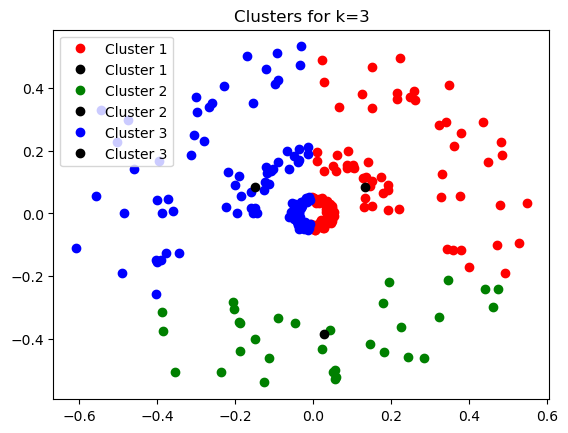

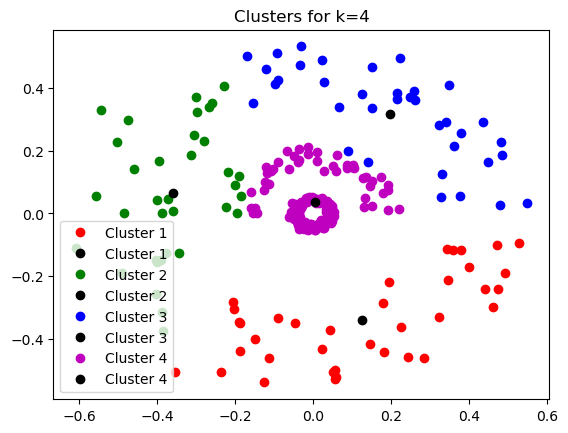

k=1, Total Error=0.09
k=2, Total Error=0.07
k=3, Total Error=0.05
k=4, Total Error=0.03
k=5, Total Error=0.02
k=6, Total Error=0.02
k=7, Total Error=0.02
k=8, Total Error=0.01
k=9, Total Error=0.01
k=10, Total Error=0.01
k=11, Total Error=0.01
k=12, Total Error=0.01
k=13, Total Error=0.01
k=14, Total Error=0.01


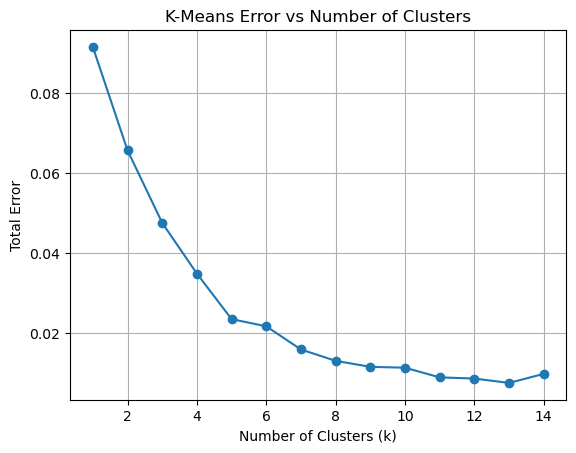

In [34]:

x,_ = make_circles(n_samples=100,noise=0.1,shuffle=False)
x1 = 0.5* x
x2 = 0.2* x[x[:,1]>0,:]
x3 = 0.05*x 

Data = np.vstack((x1,x2,x3))

plt.scatter(Data[:,0],Data[:,1])


# Cluster and plot for k=2, 3, and 4 clusters
for k in [2, 3, 4]:
    centroids, labels = k_means(Data, k)
    plot_clusters(Data, labels, k, centroids)

# Evaluate the Algorithm
# Plot error vs number of clusters (k=1 to 10)
k_values = range(1, 15)
errors = []

for k in k_values:
    centroids, labels = k_means(Data, k)
    error = calculate_inertia(Data, labels, centroids)
    errors.append(error)
    print(f"k={k}, Total Error={error:.2f}")

# Plot the error as a function of the number of clusters
plot_error_vs_clusters(k_values, errors)

<div dir="rtl">
همانطور که در نمودار بالا مشخص است، به دسته‌های منطقی نرسیدیم و این محدودیت الگوریتم را نشان می‌دهد.
</div>

## 3D -> 2D

In [35]:
a = np.array([[[1,2,3],[4,5,6],[7,8,9]], [[10,11,12],[13,14,15],[16,17,18]],[[19,20,21],[22,23,24],[25,26,27]]])
print(f"shape a: {a.shape}")
print(a)
b = a.reshape(-1,3)
print(f"\nshape b: {b.shape}")
print(b)

shape a: (3, 3, 3)
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]]

shape b: (9, 3)
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]
 [13 14 15]
 [16 17 18]
 [19 20 21]
 [22 23 24]
 [25 26 27]]


image shape: (1200, 1920, 3)
pixels shape: (2304000, 3)
labels shape: (2304000,)
centroids shape: (16, 3)
compressed_image shape: (1200, 1920, 3)


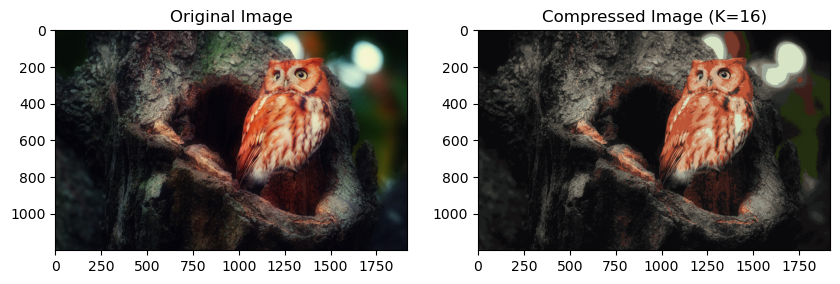

In [36]:
# Load the image
image = imread('OwlPic.jpg')
print(f"image shape: {image.shape}")

# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)
print(f"pixels shape: {pixels.shape}")

# Run the K-Means algorithm on the pixel data with k=16
k = 16
centroids, labels = k_means(pixels, k)
print(f"labels shape: {labels.shape}")
print(f"centroids shape: {centroids.shape}")

# Replace each pixel with the corresponding cluster center
compressed_image = centroids[labels].reshape(image.shape)
print(f"compressed_image shape: {compressed_image.shape}")

imsave('compressed_image.jpg', compressed_image.astype(np.uint8))

# Plot the original and compressed images for comparison
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# Compressed image
plt.subplot(1, 2, 2)
plt.imshow(compressed_image.astype(np.uint8))
plt.title('Compressed Image (K=16)')

plt.show()


# Cuda version of K-means


## kernel code

In [ ]:
kernel_code = """
__global__ void assign_clusters(float *data, float *centroids, int *labels, int num_points, int num_centroids) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;  // Global thread index

    if (idx < num_points) {
        float min_dist = 1e10;  // A large number representing infinity
        int closest_centroid = 0;

        // Find the closest centroid for each point
        for (int i = 0; i < num_centroids; i++) {
            float dist = 0.0;
            for (int j = 0; j < 3; j++) {  // Assuming 3 channels (RGB)
                float diff = data[idx * 3 + j] - centroids[i * 3 + j];
                dist += diff * diff;  // Squared Euclidean distance
            }
            if (dist < min_dist) {
                min_dist = dist;
                closest_centroid = i;
            }
        }
        labels[idx] = closest_centroid;  // Assign the closest centroid to the label
    }
}

__global__ void update_centroids(float *data, float *centroids, int *labels, int num_points, int num_centroids) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;  // Global thread index

    if (idx < num_centroids) {
        float sum[3] = {0.0, 0.0, 0.0};  // Sum of points for each centroid
        int count = 0;

        // Calculate the new centroid position
        for (int i = 0; i < num_points; i++) {
            if (labels[i] == idx) {
                for (int j = 0; j < 3; j++) {
                    sum[j] += data[i * 3 + j];
                }
                count++;
            }
        }

        // Update centroid only if count > 0 to avoid division by zero
        if (count > 0) {
            for (int j = 0; j < 3; j++) {
                centroids[idx * 3 + j] = sum[j] / count;
            }
        }
    }
}
"""

## host code

In [ ]:
# Compile the kernel code
mod = compiler.SourceModule(kernel_code)

# Function to run K-Means clustering on the GPU
def cuda_kmeans(pixels, num_classes, max_iters=100):
    num_points = pixels.shape[0]
    
    # Allocate memory on the GPU
    data_ptr = cuda.mem_alloc(pixels.nbytes)
    centroids_ptr = cuda.mem_alloc(num_classes * pixels.shape[1] * pixels.dtype.itemsize)
    labels_ptr = cuda.mem_alloc(num_points * np.int32().itemsize)

    # Copy pixel data to GPU
    cuda.memcpy_htod(data_ptr, pixels)

    # Randomly initialize centroids
    centroids = np.random.rand(num_classes, 3).astype(np.float32)
    cuda.memcpy_htod(centroids_ptr, centroids)

    for _ in range(max_iters):
        # Assign clusters
        assign_clusters = mod.get_function("assign_clusters")
        block_size = 256
        grid_size = (num_points + block_size - 1) // block_size
        assign_clusters(data_ptr, centroids_ptr, labels_ptr, np.int32(num_points), np.int32(num_classes), block=(block_size, 1, 1), grid=(grid_size, 1))

        # Update centroids
        update_centroids = mod.get_function("update_centroids")
        update_centroids(data_ptr, centroids_ptr, labels_ptr, np.int32(num_points), np.int32(num_classes), 
                 block=(block_size, 1, 1), 
                 grid=((num_classes + block_size - 1) // block_size, 1))

    # Copy results back to host
    labels = np.empty(num_points, dtype=np.int32)
    centroids = np.empty((num_classes, 3), dtype=np.float32)
    cuda.memcpy_dtoh(labels, labels_ptr)
    cuda.memcpy_dtoh(centroids, centroids_ptr)

    # Free GPU memory
    data_ptr.free()
    centroids_ptr.free()
    labels_ptr.free()

    return labels, centroids

# Example Usage
original_image = imread('OwlPic.jpg')
pixels = original_image.reshape(-1, 3).astype(np.float32)  # Flatten the image to (num_pixels, 3)

# Run K-Means on GPU
num_classes = 16
labels, centroids = cuda_kmeans(pixels, num_classes)

# Create the compressed image
compressed_image = centroids[labels].reshape(original_image.shape)
print(f"compressed_image shape: {compressed_image.shape}")

# Save the compressed image
plt.imsave('compressed_image_cuda.jpg', compressed_image.astype(np.uint8))